Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Let's display the internal variables to better understand their structure:

In [5]:
print(data[:10])
print(count[:10])
print(dictionary.items()[:10])
print(reverse_dictionary.items()[:10])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]
[['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201), ('a', 325873), ('to', 316376), ('zero', 264975), ('nine', 250430)]
[('fawn', 45848), ('homomorphism', 9648), ('nordisk', 39343), ('nunnery', 36075), ('chthonic', 33554), ('sowell', 40562), ('sonja', 38175), ('showa', 32906), ('woods', 6263), ('hsv', 44222)]
[(0, 'UNK'), (1, 'the'), (2, 'of'), (3, 'and'), (4, 'one'), (5, 'in'), (6, 'a'), (7, 'to'), (8, 'zero'), (9, 'nine')]


Function to generate a training batch for the skip-gram model.

In [6]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:32]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])
    
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 1
    batch, labels = generate_batch(batch_size=16, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(16)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'UNK', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term', 'of', 'of', 'abuse', 'abuse', 'first', 'first', 'used', 'used']
    labels: ['anarchism', 'as', 'originated', 'a', 'as', 'term', 'a', 'of', 'term', 'abuse', 'first', 'of', 'abuse', 'used', 'against', 'first']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a', 'term', 'term', 'term', 'term', 'of', 'of', 'of', 'of']
    labels: ['term', 'originated', 'a', 'anarchism', 'originated', 'as', 'of', 'term', 'a', 'of', 'as', 'abuse', 'term', 'first', 'a', 'abuse']

with num_skips = 2 and skip_window = 1:
    batch: ['as', 'as', 'a', 'a', 'te

Note: the labels is a sliding random value of the word surrounding the words of the batch.

It is not obvious with the output above, but all the data are based on index, and not the word directly.

In [7]:
print(batch)
print(labels)

[   6    6    6    6  195  195  195  195    2    2    2    2 3137 3137 3137
 3137]
[[  12]
 [   2]
 [3084]
 [ 195]
 [   6]
 [  12]
 [   2]
 [3137]
 [   6]
 [  46]
 [3137]
 [ 195]
 [  59]
 [  46]
 [   2]
 [ 195]]


Train a skip-gram model.

In [10]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [11]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.811983
Nearest to had: magma, intermediate, nico, shocking, fennel, mahommed, bullfighting, losing,
Nearest to were: soaked, whiz, mingling, about, testified, saleh, visited, catheter,
Nearest to after: solidarity, parrish, textile, erased, stack, quart, optional, shropshire,
Nearest to if: insulinotherapy, southernmost, incur, rush, replica, tert, fanu, districts,
Nearest to been: documents, cbe, bolt, concludes, xxiv, zy, amarna, barnes,
Nearest to four: radbruch, malraux, spelled, ulema, olomouc, irix, districts, fission,
Nearest to six: lightning, selecting, annexing, thurgood, sola, strat, bolstering, fabricate,
Nearest to no: woollen, freeh, indies, adler, employees, cyprian, overboard, unaspirated,
Nearest to years: raid, wirth, funniest, rearranged, eleusinian, foci, p, extensions,
Nearest to history: mystique, cathedrals, drawing, updating, blount, laughed, distributes, distrusted,
Nearest to have: northeast, solutions, byron, variegated, 

Average loss at step 52000: 3.437181
Average loss at step 54000: 3.424874
Average loss at step 56000: 3.439141
Average loss at step 58000: 3.395519
Average loss at step 60000: 3.393265
Nearest to had: has, have, was, were, never, been, having, began,
Nearest to were: are, have, was, had, those, distorts, including, be,
Nearest to after: before, during, when, despite, until, while, if, following,
Nearest to if: when, though, where, before, because, since, while, will,
Nearest to been: become, be, was, were, already, had, redirection, monaco,
Nearest to four: five, six, eight, three, seven, nine, two, zero,
Nearest to six: eight, four, five, nine, seven, three, zero, one,
Nearest to no: any, little, adler, tito, a, trie, another, kites,
Nearest to years: days, months, year, times, decades, minutes, weeks, rearranged,
Nearest to history: list, zappa, tabulating, hollerith, encyclopedia, perpetrated, museum, woodlands,
Nearest to have: had, has, were, are, be, require, having, produce,
Nea

This is what an embedding looks like:

In [12]:
print(final_embeddings[0])

[ 0.01632174 -0.00043203 -0.10727748 -0.00807389 -0.03674715 -0.19748732
  0.00563976  0.01881355 -0.08622659  0.01810788 -0.01024211  0.12067884
  0.11154344  0.05491059  0.08393572 -0.16309366  0.09331696 -0.1538225
  0.01436835  0.06241069 -0.00516229  0.11195109 -0.06775691 -0.03493737
  0.14637201 -0.0901556   0.05458238  0.05824662 -0.03270516  0.09064501
 -0.02964827 -0.0217908   0.00725084 -0.05625057  0.01087124 -0.01608189
 -0.09277114 -0.05342438 -0.01129807 -0.02889235  0.00543865  0.00674712
  0.04648234  0.09025926 -0.1247657   0.09588847  0.17207454 -0.03825257
  0.15597047  0.0422233  -0.00057414  0.03356871 -0.00591294 -0.01610811
  0.06046534 -0.03020891 -0.10258555 -0.02389908  0.1949323  -0.06090993
  0.10163122 -0.03994744  0.00510642 -0.096294   -0.00764961  0.14654978
 -0.06056517  0.05779802  0.14515859 -0.0081378  -0.06518395 -0.0135632
  0.04833939  0.00465398  0.04736794  0.02920877 -0.11491748  0.03286517
  0.04266714 -0.03314333  0.02191134 -0.31086907 -0.0

All the values are abstract, there is practical meaning of the them. Moreover, the final embeddings are normalized as you can see here:

In [13]:
print(np.sum(np.square(final_embeddings[0])))

1.0


In [14]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

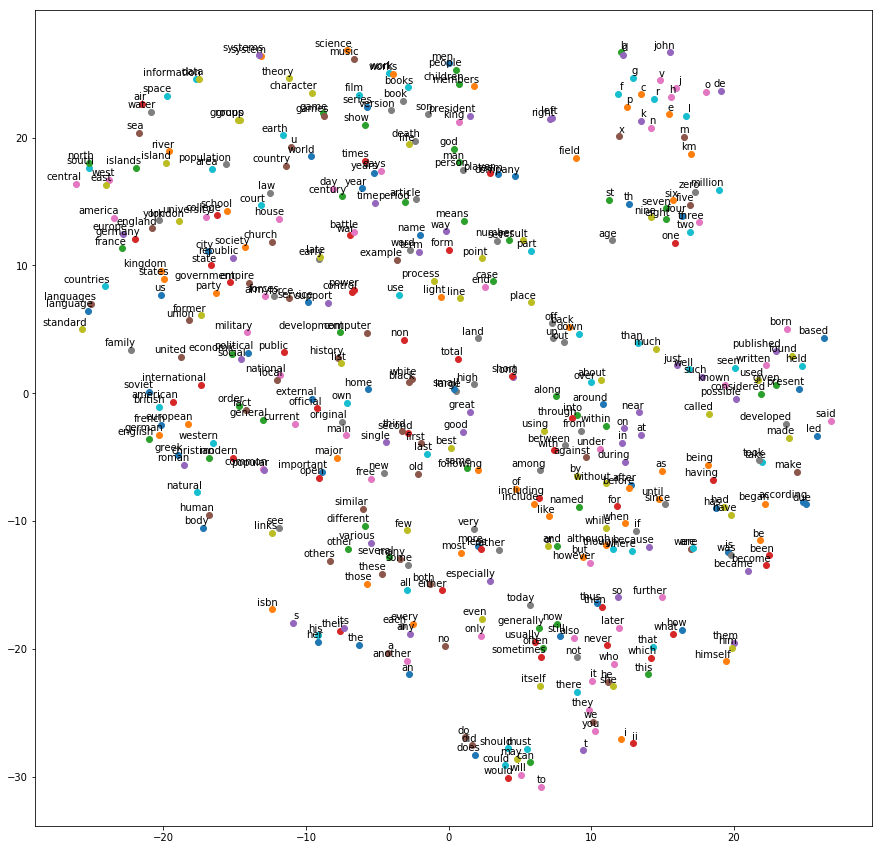

In [15]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

For the continuous bag of words, the train inputs are slightly different from the skip-gram:

In [16]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    # just for testing
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(bag_window)
    batch[i] = buffer_list
    # iterate to the next buffer
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
  data_index = 0
  batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
  print('\nwith bag_window = %d:' % (bag_window))  
  print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
  print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


Note the instruction change on the loss function, with reduce_sum to sum the word vectors in the context:

In [17]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
###skip_window = 1 # How many words to consider left and right.
###num_skips = 2 # How many times to reuse an input to generate a label.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, tf.reduce_sum(embeds, 1),
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [18]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.475554
Nearest to a: cricketers, fierro, connacht, strip, tupolev, unfaithful, nieuwe, wipo,
Nearest to see: howe, delineate, celesta, vj, installments, salmonella, uiuc, businessweek,
Nearest to it: quadrant, matte, vows, vulgar, pneumatic, hemionus, permanence, consecrate,
Nearest to can: pantheism, quotient, copy, antes, n, condemn, fined, abdal,
Nearest to they: leans, cited, shehhi, kickapoo, siam, commercialized, eugenicist, addressed,
Nearest to in: sufferers, inhaling, eutelsat, rijeka, accomplishments, peloponnesian, unavoidable, directions,
Nearest to there: arameans, raping, wpm, episcopi, discontented, elaine, ahenobarbus, pensions,
Nearest to will: elijah, jargon, innovative, nixon, xor, adverbial, galileo, gilgal,
Nearest to would: schlick, actus, hbar, finale, ragnarok, unido, giuliano, heartbroken,
Nearest to known: masoretes, lush, mfm, jutland, alioth, errol, levites, nrsv,
Nearest to however: pavements, atmosphere, kenyatta, pier

Average loss at step 52000: 3.114086
Average loss at step 54000: 3.117589
Average loss at step 56000: 2.953412
Average loss at step 58000: 3.053592
Average loss at step 60000: 3.072947
Nearest to a: another, any, no, every, the, an, its, this,
Nearest to see: ammanati, tetzel, includes, references, conjugated, telco, refers, semantically,
Nearest to it: he, this, mana, she, asexual, pascha, dempsey, dominic,
Nearest to can: may, must, should, cannot, could, might, will, would,
Nearest to they: you, we, he, she, there, emerge, vindication, humans,
Nearest to in: within, throughout, during, since, on, despite, hallstatt, hartley,
Nearest to there: longer, interment, they, undiscovered, expected, dempsey, it, granted,
Nearest to will: must, would, could, may, can, should, might, cannot,
Nearest to would: could, will, might, must, should, may, cannot, can,
Nearest to known: used, defined, described, referred, seen, possible, required, considered,
Nearest to however: although, which, though

In [19]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

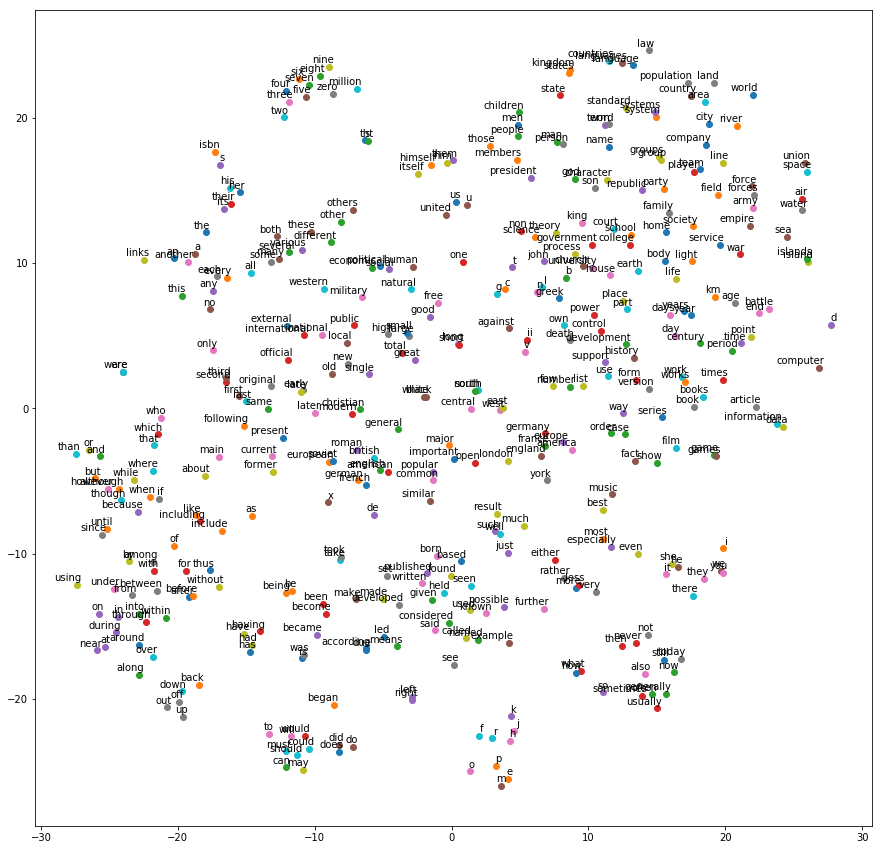

In [20]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

Some clusters are less obvious (like the standalone characters), but it clearly totaly works!